In [1]:
import os
import cv2
import dlib
import shutil
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.face_align import norm_crop

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [3]:
def get_5_landmarks(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return "No faces detected"
    landmarks = predictor(gray, faces[0])
    points = [(landmarks.part(i).x, landmarks.part(i).y) for i in [36, 45, 30, 48, 54]]
    for pt in points:
        cv2.circle(img, pt, 2, (0, 255, 0), -1)

    return points

In [4]:
def load_data_folder(path_folder):
    file_ext = ['.jpg', '.JPG', '.png', '.PNG']
    file_paths = list()
    for name in os.listdir(path_folder):
        if os.path.splitext(name)[1] in file_ext:
            file_paths.append(os.path.join(path_folder, name))
    file_paths = sorted(file_paths)
    return file_paths

In [5]:
def copy_image(source_path, destination_directory):
    if not os.path.exists(source_path):
        print(f"The file '{source_path}' does not exist.")
        return
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)
    image_name = os.path.basename(source_path)
    destination_path = os.path.join(destination_directory, image_name)
    shutil.copy2(source_path, destination_path)
    print(f"Image successfully copied to {destination_path}.")

In [6]:
def crop_align_images(source_directory, destination_directory):
    error_tokens = []
    image_paths = load_data_folder(source_directory)
    for image_path in tqdm(image_paths):
        try:
            image_name = os.path.basename(image_path)
            image = cv2.imread(image_path)
            landmarks = np.array(get_5_landmarks(image_path))
            aligned_image = norm_crop(image, landmarks, image_size=112, mode='arcface')
            destination_path = os.path.join(destination_directory, image_name)
            cv2.imwrite(destination_path, aligned_image)
        except:
            error_tokens.append(image_name.split('_')[0])
    return error_tokens

In [7]:
def copy_and_remove(image_path, target_folder):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    image_name = os.path.basename(image_path)
    shutil.copy(image_path, os.path.join(target_folder, image_name))

    os.remove(image_path)  # Remove original image

In [8]:
def get_token(path):
    return path.split("_")[0]

In [9]:
def remove_unpaired_images(folder_1, folder_2):
    tokens_folder1 = {name: get_token(name) for name in os.listdir(folder_1)}
    tokens_folder2 = {name: get_token(name) for name in os.listdir(folder_2)}

    unpaired_images_folder1 = {name for name, token in tokens_folder1.items() if token not in tokens_folder2.values()}
    unpaired_images_folder2 = {name for name, token in tokens_folder2.items() if token not in tokens_folder1.values()}

    for image in unpaired_images_folder1:
        os.remove(os.path.join(folder_1, image))

    for image in unpaired_images_folder2:
        os.remove(os.path.join(folder_2, image))

    print(f"Removed {len(unpaired_images_folder1)} images from {folder_1}")
    print(f"Removed {len(unpaired_images_folder2)} images from {folder_2}")


In [10]:
def compare_random_images(list1, list2):

    if len(list1) != len(list2):
        print("Both lists must have the same number of images for comparison.")
        return

    random_indices = random.sample(range(len(list1)), 5)

    fig, axes = plt.subplots(5, 2, figsize=(10, 10))
    
    for i, idx in enumerate(random_indices):
        img1, img2 = Image.open(list1[idx]), Image.open(list2[idx])

        axes[i, 0].imshow(img1)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'List 1 - Image {idx+1}')
        
        axes[i, 1].imshow(img2)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f'List 2 - Image {idx+1}')

    plt.tight_layout()
    plt.show()

In [11]:
image_paths_front = load_data_folder('dataset_chl2/front/')
image_paths_front_align = load_data_folder('dataset_chl2/front_align/')
image_paths_selfie = load_data_folder('dataset_chl2/selfie/')
image_paths_selfie_align = load_data_folder('dataset_chl2/selfie_align/')

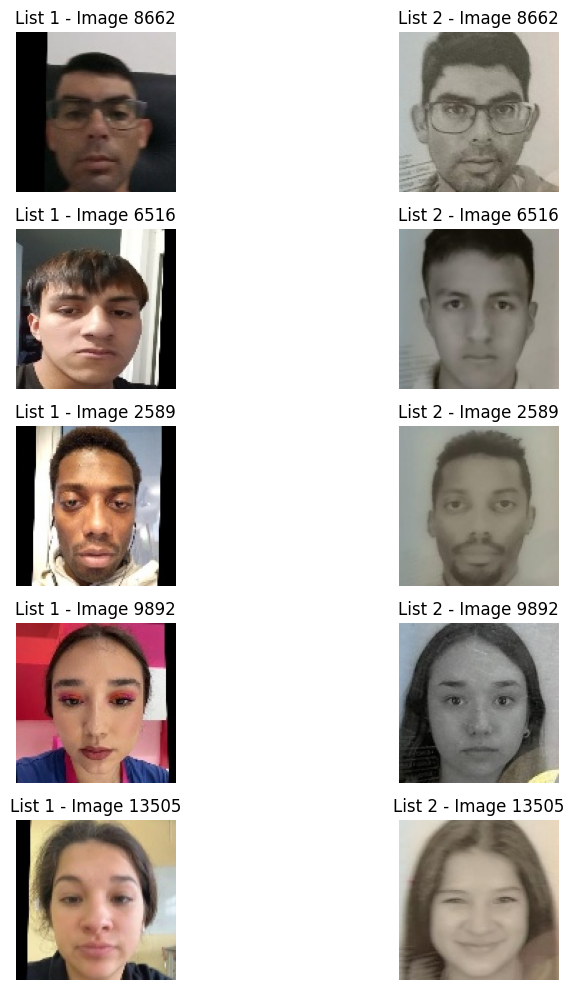

In [12]:
compare_random_images(image_paths_selfie_align,image_paths_front_align)

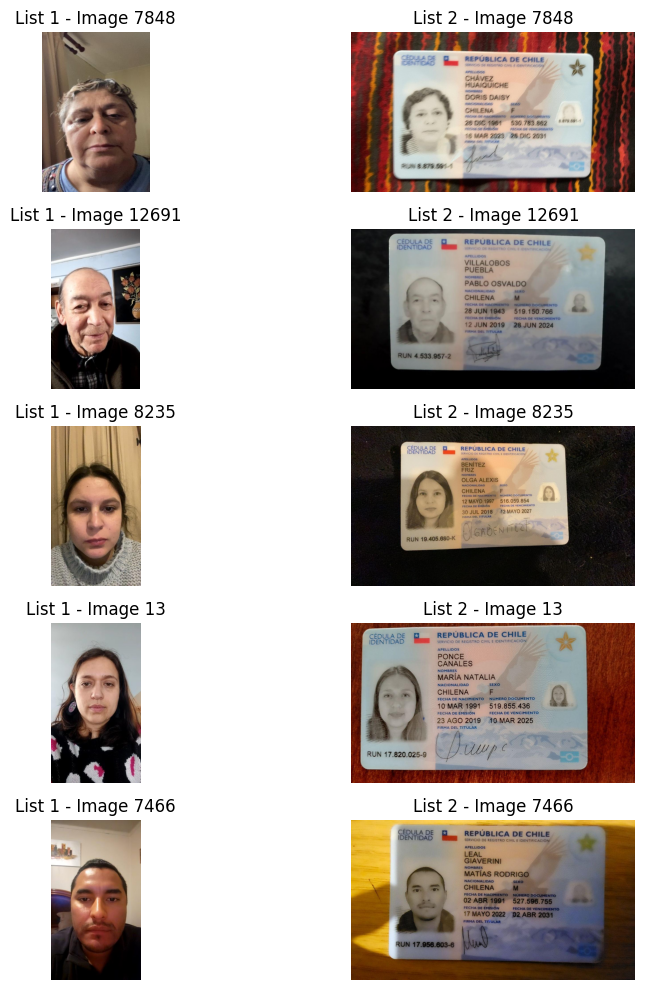

In [13]:
compare_random_images(image_paths_selfie,image_paths_front)